In [1]:
import h5py
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt

In [2]:
tab = Table.read("/group/ja3/athomson/spice-racs.dr1.corrected.xml")

In [3]:
spectra = h5py.File("/group/ja3/athomson/full_spica/casda/spice_racs_dr1_polspec.hdf5")[
    "polspectra"
]

In [29]:
# idx = np.argmax(tab["stokesI"])
idx = np.where(tab["stokesI"]==np.percentile(tab["stokesI"], 97, method="nearest"))[0][0]

In [30]:
row = tab[idx]

In [31]:
spectra[row["cat_id"]]["stokesI"]

<HDF5 dataset "stokesI": shape (288,), type "<f8">

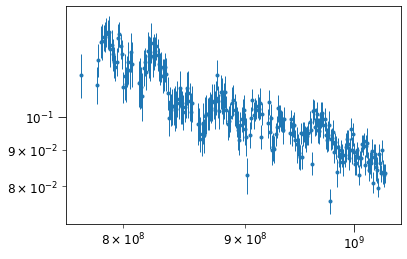

In [32]:
plt.errorbar(
    spectra[row["cat_id"]]["freq"][:],
    spectra[row["cat_id"]]["stokesI"][:],
    yerr=spectra[row["cat_id"]]["stokesI_error"][:],
    fmt=".",
)
plt.xscale("log")
plt.yscale("log")

In [71]:
from scipy.optimize import curve_fit
from functools import partial

# Stolen from GLEAM-X - thanks Uncle Timmy!
def power_law(nu: np.ndarray, norm: float, alpha: float, ripple: float, ref_nu: float) -> np.ndarray:
    """A power law model.

    Args:
        nu (np.ndarray): Frequency array.
        norm (float): Reference flux.
        alpha (float): Spectral index.
        ref_nu (float): Reference frequency.

    Returns:
        np.ndarray: Model flux.
    """
    return norm * (nu / ref_nu) ** alpha * np.sin(2 * np.pi * (nu / ripple))

def fit_pl(freq: np.ndarray, flux: np.ndarray, fluxerr: np.ndarray) -> dict:
    """Perform a power law fit to a spectrum.

    Args:
        freq (np.ndarray): Frequency array.
        flux (np.ndarray): Flux array.
        fluxerr (np.ndarray): Error array.

    Returns:
        dict: Best fit parameters.
    """
    goodchan=np.logical_and(np.isfinite(flux),np.isfinite(fluxerr)) #Ignore NaN channels!
    ref_nu = np.nanmean(freq[goodchan])
    p0 = (np.median(flux[goodchan]), -0.8, 25*1e6)
    try:
        fit_res = curve_fit(
            partial(power_law, ref_nu=ref_nu),
            freq[goodchan],
            flux[goodchan],
            p0=p0,
            sigma=fluxerr[goodchan],
            absolute_sigma=True
        )
    except RuntimeError:
        return dict(
            norm=np.nan,
            alpha=np.nan,
            norm_err=np.nan,
            alpha_err=np.nan,
            chi2=np.nan,
            rchi2=np.nan,
            dof=np.nan,
            ref_nu=np.nan,
            model_arr=np.nan,
            ripple=np.nan,
        )

    best_p, covar = fit_res
    err_p = np.sqrt(np.diag(covar))
    dof = len(freq) - 2
    model_arr = power_law(freq, *best_p, ref_nu=ref_nu)
    chi2 = np.sum(
        ((flux - model_arr) / fluxerr)**2
        )
    rchi2 = chi2 / dof

    return dict(
        norm=best_p[0],
        alpha=best_p[1],
        norm_err=err_p[0],
        alpha_err = err_p[1],
        ripple = best_p[2],
        ripple_err = err_p[2],
        chi2=chi2,
        rchi2=rchi2,
        dof=dof,
        ref_nu=ref_nu,
        model_arr=model_arr,
        # ripple=ripple,
    )

# def power_law(nu, norm, alpha, ref_nu):
#     return norm * (nu / ref_nu) ** alpha


# def curved_power_law(nu, norm, alpha, q, ref_nu):
#     spec_nu = nu / ref_nu
        
#     return norm * spec_nu ** alpha * \
#             np.exp(q * np.log(spec_nu)**2)

# def fit_pl(freq, flux, fluxerr):

#     goodchan=np.logical_and(np.isfinite(flux),np.isfinite(fluxerr)) #Ignore NaN channels!
#     ref_nu = np.nanmean(freq[goodchan])
#     p0 = (np.median(flux[goodchan]), -0.8)
#     try:
#         fit_res = curve_fit(
#             partial(power_law, ref_nu=ref_nu),
#             freq[goodchan],
#             flux[goodchan],
#             p0=p0,
#             sigma=fluxerr[goodchan],
#             absolute_sigma=True
#         )
#     except RuntimeError:
#         return None

#     best_p, covar = fit_res
#     err_p = np.sqrt(np.diag(covar))
#     dof = len(freq) - 2
#     model_arr = power_law(freq, *best_p, ref_nu=ref_nu)
#     chi2 = np.sum(
#         ((flux - model_arr) / fluxerr)**2
#         )
#     rchi2 = chi2 / dof

#     return dict(
#         norm=best_p[0], 
#         alpha=best_p[1],
#         norm_err=err_p[0],
#         alpha_err = err_p[1],
#         chi2=chi2,
#         rchi2=rchi2,
#         dof=dof,
#         ref_nu=ref_nu,
#         model_arr=model_arr,
#     )


# def fit_cpl(freq, flux, fluxerr):
#     p0 = (np.median(flux), -0.8, 0)

#     try:
#         fit_res = curve_fit(
#             curved_power_law,
#             freq,
#             flux,
#             p0=p0,
#             sigma=fluxerr,
#             absolute_sigma=True
#         )
#     except RuntimeError:
#         return None

#     best_p, covar = fit_res
#     err_p = np.sqrt(np.diag(covar))
#     dof = len(freq) - 3
#     chi2 = np.sum(
#         ((flux - curved_power_law(freq, *best_p)) / fluxerr)**2
#         )
#     rchi2 = chi2 / dof
#     return dict(
#         norm=best_p[0], 
#         alpha=best_p[1],
#         q=best_p[2],
#         norm_err=err_p[0],
#         alpha_err = err_p[1],
#         q_err=err_p[2],
#         chi2=chi2,
#         rchi2=rchi2,
#         dof=dof
#         )

In [72]:
fit_dict = fit_pl(
    spectra[row["cat_id"]]["freq"][:],
    spectra[row["cat_id"]]["stokesI"][:],
    spectra[row["cat_id"]]["stokesI_error"][:]
)
# fit_dict

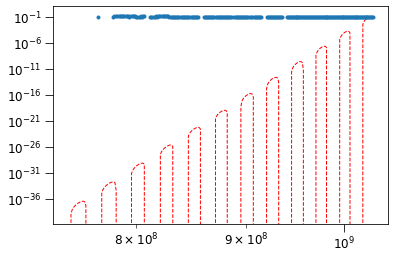

In [73]:
pl_res = fit_dict
# pl_reject =  pl_res['chi2'] > chi2.ppf(0.99, pl_res['dof'])
pl_params = [pl_res[i] for i in ['norm', 'alpha', 'ripple']]
nu = spectra[row["cat_id"]]["freq"][:]

plt.plot(
    nu,
    power_law(nu, *pl_params, ref_nu=pl_res['ref_nu']),
    ls='--',
    color='red',
    # label=f"Power-law, r$\chi^2$  {pl_res['rchi2']:.3f}, reject {pl_reject}"
)
plt.errorbar(
    spectra[row["cat_id"]]["freq"][:],
    spectra[row["cat_id"]]["stokesI"][:],
    yerr=spectra[row["cat_id"]]["stokesI_error"][:],
    fmt=".",
)
plt.xscale("log")
plt.yscale("log")

In [36]:
from RMtools_1D import do_RMsynth_1D

In [37]:
data = [
    spectra[row["cat_id"]]["freq"][:], 
    spectra[row["cat_id"]]["stokesI"][:], 
    spectra[row["cat_id"]]["stokesQ"][:], 
    spectra[row["cat_id"]]["stokesU"][:], 
    spectra[row["cat_id"]]["stokesI_error"][:], 
    spectra[row["cat_id"]]["stokesQ_error"][:], 
    spectra[row["cat_id"]]["stokesU_error"][:]
]

In [50]:
%%timeit
mDict, aDict = do_RMsynth_1D.run_rmsynth(
    data=data,
    polyOrd=2,
    phiMax_radm2=None,
    dPhi_radm2=None,
    nSamples=10,
    weightType="variance",
    fitRMSF=True,
    noStokesI=False,
    modStokesI=None,
    nBits=32,
    saveFigures=False,
    showPlots=False,
    verbose=False,
    debug=False,
    fit_function="log",
    prefixOut=None,
)

496 ms ± 3.78 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [51]:
%%timeit
mDict, aDict = do_RMsynth_1D.run_rmsynth(
    data=data,
    polyOrd=2,
    phiMax_radm2=None,
    dPhi_radm2=None,
    nSamples=10,
    weightType="variance",
    fitRMSF=True,
    noStokesI=False,
    modStokesI=None,
    nBits=32,
    saveFigures=False,
    showPlots=False,
    verbose=True,
    debug=False,
    fit_function="log",
    prefixOut=None,
)

> Trying [freq_Hz, I, Q, U, dI, dQ, dU] ... success.
Successfully read in the Stokes spectra.
Plotting the input data and spectral index fit.
PhiArr = -3975.30 to 3975.30 by 4.45 (1787 chans).
Weight type is 'variance'.
Running RM-synthesis by channel.
  [========================================] 100%
Calculating 1D RMSF and replicating along X & Y axes.
Fitting Gaussian to the main lobe.
> RM-synthesis completed in 1.27 seconds.

--------------------------------------------------------------------------------
RESULTS:

FWHM RMSF = 54.3 rad/m^2
Pol Angle = 17.79 (+/-4.585) deg
Pol Angle 0 = 139.2 (+/-24.29) deg
Peak FD = -18.34 (+/-4.345) rad/m^2
freq0_GHz = 0.8819 
I freq0 = 0.1031 Jy/beam
Peak PI = 0.0004602 (+/-7.365e-05) Jy/beam
QU Noise = 0.001279 Jy/beam
FDF Noise (theory)   = 7.365e-05 Jy/beam
FDF Noise (Corrected MAD) = 6.254e-05 Jy/beam
FDF Noise (rms)   = 0.0001304 Jy/beam
FDF SNR = 6.248 
sigma_add(q) = 0.02819 (+0.09736, -0.02008)
sigma_add(u) = 0.04124 (+0.1578, -0.03332)


In [47]:
mDict, aDict = do_RMsynth_1D.run_rmsynth(
    data=data,
    polyOrd=2,
    phiMax_radm2=None,
    dPhi_radm2=None,
    nSamples=10,
    weightType="variance",
    fitRMSF=True,
    noStokesI=False,
    modStokesI=None,
    nBits=32,
    saveFigures=False,
    showPlots=False,
    verbose=False,
    debug=False,
    fit_function="log",
    prefixOut=None,
)
print(mDict["polyCoeffs"])
print(mDict["polyCoefferr"])

0.0,0.0,0.0,3.1382655282919676,-1.27181698654508,0.09936123666616102
0.0,0.0,0.0,1.0992576067877982,0.03528437780403348,0.00043642697307509024


In [49]:
mDict, aDict = do_RMsynth_1D.run_rmsynth(
    data=data,
    polyOrd=2,
    phiMax_radm2=None,
    dPhi_radm2=None,
    nSamples=10,
    weightType="variance",
    fitRMSF=True,
    noStokesI=False,
    modStokesI=fit_dict["model_arr"],
    nBits=32,
    saveFigures=False,
    showPlots=False,
    verbose=False,
    debug=False,
    fit_function="log",
    prefixOut=None,
)
print(mDict["polyCoeffs"])
print(mDict["polyCoefferr"])

Using provided model Stokes I spectrum
0.0,0.0,0.0,0.0,0.0,1.0
0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
len(mDict["polyCoeffs"])

23

In [61]:
alpha = fit_dict["alpha"]
amplitude = fit_dict["norm"]
x_0 = fit_dict["ref_nu"]
modStokesI = fit_dict["model_arr"]
model_repr = None


'0.0,0.0,0.0,0.10028280093766442,-1.2716316650762638'

In [62]:
fit_dict

{'norm': 0.10028280093766442,
 'alpha': -1.2716316650762638,
 'norm_err': 0.00029297711216633073,
 'alpha_err': 0.03554805587626449,
 'chi2': nan,
 'rchi2': nan,
 'dof': 286,
 'ref_nu': 907226792.2428458,
 'model_arr': array([0.12905517, 0.12883493, 0.12861535, 0.12839644, 0.1281782 ,
        0.12796062, 0.1277437 , 0.12752743, 0.12731182, 0.12709686,
        0.12688254, 0.12666887, 0.12645585, 0.12624346, 0.1260317 ,
        0.12582059, 0.1256101 , 0.12540024, 0.125191  , 0.12498239,
        0.1247744 , 0.12456703, 0.12436027, 0.12415412, 0.12394859,
        0.12374366, 0.12353933, 0.12333561, 0.12313248, 0.12292996,
        0.12272802, 0.12252668, 0.12232593, 0.12212576, 0.12192618,
        0.12172719, 0.12152877, 0.12133092, 0.12113366, 0.12093696,
        0.12074084, 0.12054528, 0.12035028, 0.12015585, 0.11996198,
        0.11976867, 0.11957592, 0.11938371, 0.11919206, 0.11900096,
        0.1188104 , 0.11862039, 0.11843092, 0.11824199, 0.1180536 ,
        0.11786575, 0.11767842, 0.